<a href="https://colab.research.google.com/github/tombrash/handson-ml2/blob/master/workbooks/ch14/mnist_data_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST classification

Workbook to classify handwritten images in MNIST database using a convolutional neural network.

In this model, data augmentation is used to provide an artificially enhanced set of data to learn from.

### Import key libraries

In [18]:
# Key imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import data

Compared to previous versions of this task, keras dataset is used for greater compatibility with tensorflow preprocessing (oddly better than tensorflow.data format for this purpose)

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train = X_train_full[:50000] / 255.0
X_val = X_train_full[50000:] / 255.0
y_train = y_train_full[:50000]
y_val = y_train_full[50000:]

# also feature normalize x_test
X_test = X_test / 255.0

# add a dimension to match required shape in keras
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

### Create model

Model created using high level Keras API

In [4]:
keras.backend.clear_session()

# create the model

model = keras.Sequential([
          layers.Conv2D(32, 3, padding='SAME', input_shape=[28, 28, 1],
                        activation='relu'),
          layers.Conv2D(32, 3, padding='SAME', activation='relu'),             
          layers.MaxPooling2D(2),
          layers.Dropout(0.25),
          layers.Conv2D(64, 3, padding='SAME', activation='relu'),             
          layers.Conv2D(64, 3, padding='SAME', activation='relu'),
          layers.MaxPooling2D(2),
          layers.Dropout(0.25),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dropout(0.25),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.5),
          layers.Dense(10, activation='softmax'),
])

In [5]:
model.compile(optimizer='nadam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [7]:
# Create data generator to train model on
# generator should:
#    rotate images between 0 and 10 degrees
#    zoom up to 10%
#    perform horizontal and vertical shifts of up to 10%

datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

In [6]:
# create relevant callbacks

modelcheckpoint_cb = keras.callbacks.ModelCheckpoint('mnist_model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                 restore_best_weights=True)
learningrate_cb = keras.callbacks.ReduceLROnPlateau(patience=3, 
                                                    verbose=1,
                                                    factor=0.4, 
                                                    min_lr=0.000001)

callbacks = [modelcheckpoint_cb, earlystopping_cb, learningrate_cb]

### Run model

In order to achieve best performance, epochs should be set to at least 20. 

Accuracy of 99.4% can be achieve with 5 epochs, but 99.6% or better requires at least 20 epochs. Running this on a GPU or TPU will dramatically increase processing speed

In [11]:
epochs = 30
batch_size = 32

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Epoch 6/20
1562/1562 [==============================] - 228s 146ms/step - loss: 0.0826 - accuracy: 0.9794 - val_loss: 0.0310 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 7/20
1562/1562 [==============================] - 231s 148ms/step - loss: 0.0807 - accuracy: 0.9805 - val_loss: 0.0322 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 8/20
1562/1562 [==============================] - 231s 148ms/step - loss: 0.0717 - accuracy: 0.9817 - val_loss: 0.0352 - val_accuracy: 0.9909 - lr: 0.0010
Epoch 9/20
1562/1562 [==============================] - 233s 149ms/step - loss: 0.0680 - accuracy: 0.9835 - val_loss: 0.0304 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 10/20
1562/1562 [==============================] - 233s 149ms/step - loss: 0.0639 - accuracy: 0.9838 - val_loss: 0.0311 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 11/20
1562/1562 [==============================] - 233s 149ms/step - loss: 0.0595 - accuracy: 0.9850 - val_loss: 0.0252 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 12/20
1562/1562 [=========

In [12]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 9s 29ms/step - loss: 0.0142 - accuracy: 0.9962


[0.014229530468583107, 0.9962000250816345]

In [13]:
model.save('mnist_best_model.h5')

In [16]:
history_data = pd.DataFrame(history.history)

### Overview of results (fixed)

Note that this compares results from a number of models that are not included in this workbook. All results are hardcoded and will not be updated by running the above models

In [47]:
results_comp = pd.DataFrame([['Logistic Regression', 0.91],
                ['Conventional NN', 0.97],
                ['Simple CNN', 0.988],
                ['Complex CNN', 0.989],
                ['Final CNN Model (5 epochs)', 0.994],
                ['Final CNN Model (20 epochs)', 0.996]])
results_comp.columns = ['model', 'accuracy']

Text(0.5, 1.0, 'Comparison of MNIST models')

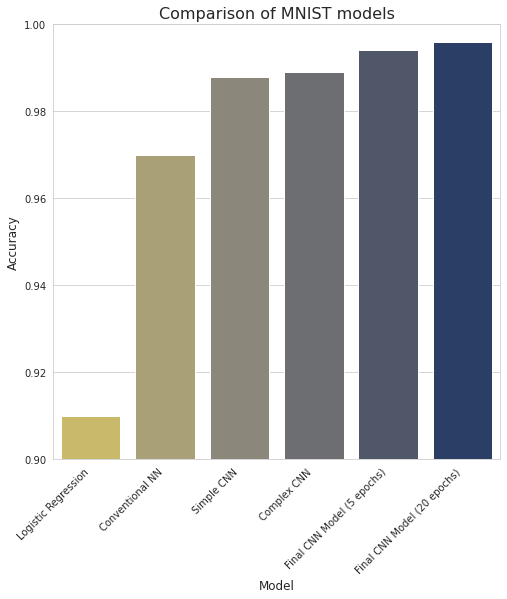

In [48]:
sns.set_palette('cividis_r')
sns.set_style('whitegrid')
fig =plt.figure(figsize=(8,8))
sns.barplot(x='model', y='accuracy', data=results_comp)
plt.ylim((0.9,1))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model', fontdict={'fontsize': 12})
plt.ylabel('Accuracy', fontdict={'fontsize': 12})
plt.title('Comparison of MNIST models', fontdict={'fontsize':16})
